In [ ]:
%matplotlib inline

## 1. Model Creation



In [ ]:
import numpy as np
import tf_keras as keras
from tf_keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Akida expects NHWC 4D
x_train = np.expand_dims(x_train, -1).astype(np.uint8)  # (N,28,28,1)
x_test  = np.expand_dims(x_test,  -1).astype(np.uint8)

y_train = y_train.astype(np.int32)
y_test  = y_test.astype(np.int32)


2025-12-14 23:55:57.258093: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765774557.273103   17914 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765774557.277767   17914 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765774557.289873   17914 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765774557.289889   17914 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765774557.289890   17914 computation_placer.cc:177] computation placer alr

In [ ]:
import tf_keras as keras

def make_mnist_cnn_v1_safe():
    return keras.Sequential([
        keras.layers.Input(shape=(28, 28, 1)),
        keras.layers.Rescaling(1./255),

        keras.layers.Conv2D(16, 3, padding="same", use_bias=True),
        keras.layers.ReLU(max_value=6.0),

        keras.layers.Conv2D(32, 3, strides=2, padding="same", use_bias=True),
        keras.layers.ReLU(max_value=6.0),

        keras.layers.Conv2D(64, 3, strides=2, padding="same", use_bias=True),
        keras.layers.ReLU(max_value=6.0),

        keras.layers.Flatten(),
        keras.layers.Dense(10),
    ], name="mnist_akida_v1_safe")

model_fp32 = make_mnist_cnn_v1_safe()
model_fp32.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
model_fp32.fit(x_train, y_train, epochs=5, batch_size=256, validation_split=0.1)


Epoch 1/5


2025-12-14 23:56:00.979230: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


211/211 [==============================] - 6s 27ms/step - loss: 0.4671 - accuracy: 0.8692 - val_loss: 0.1355 - val_accuracy: 0.9630
Epoch 2/5
211/211 [==============================] - 6s 27ms/step - loss: 0.1182 - accuracy: 0.9652 - val_loss: 0.0848 - val_accuracy: 0.9758
Epoch 3/5
211/211 [==============================] - 6s 27ms/step - loss: 0.0792 - accuracy: 0.9764 - val_loss: 0.0659 - val_accuracy: 0.9822
Epoch 4/5
211/211 [==============================] - 6s 27ms/step - loss: 0.0603 - accuracy: 0.9819 - val_loss: 0.0604 - val_accuracy: 0.9840
Epoch 5/5
211/211 [==============================] - 6s 27ms/step - loss: 0.0508 - accuracy: 0.9845 - val_loss: 0.0550 - val_accuracy: 0.9848


## 2. Quantization

In [ ]:
from quantizeml.models import quantize, QuantizationParams

qparams = QuantizationParams(input_weight_bits=4, weight_bits=4, activation_bits=4)

model_q = quantize(
    model_fp32,
    qparams=qparams,
    samples=x_train,
    num_samples=2048,
    batch_size=256,
    epochs=1
)


8/8 [==============================] - 0s 9ms/step


In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""   # must be set BEFORE importing tf_keras


In [ ]:
from pathlib import Path
print(Path("/sys/class/powercap/intel-rapl:0/energy_uj").read_text().strip())



248944440459


## 3. CPU Testing

In [ ]:
import os, time, statistics
from pathlib import Path
import numpy as np
import tensorflow as tf

# ----------------------------
# RAPL helpers
# ----------------------------
def _read_int(path: str) -> int:
    return int(Path(path).read_text().strip())

def discover_rapl_domains(base="/sys/class/powercap"):
    """
    Returns dict like {"package": path, "core": path, "dram": path} for intel-rapl:0*
    """
    domains = {}
    root = Path(base)

    # Common locations you've shown exist:
    candidates = [
        root / "intel-rapl:0",
        root / "intel-rapl:0:0",
        root / "intel-rapl:0:1",
    ]

    for d in candidates:
        if not d.exists():
            continue
        name_file = d / "name"
        energy_file = d / "energy_uj"
        if name_file.exists() and energy_file.exists():
            name = name_file.read_text().strip()
            # map linux names to friendly keys
            key = "package" if name.startswith("package") else name
            domains[key] = str(energy_file)

    # Fallback: scan deeper for any intel-rapl:0:* domain
    if not domains:
        for p in root.glob("intel-rapl:0*"):
            if p.is_dir() and (p/"name").exists() and (p/"energy_uj").exists():
                name = (p/"name").read_text().strip()
                key = "package" if name.startswith("package") else name
                domains[key] = str(p/"energy_uj")

    if not domains:
        raise RuntimeError("No RAPL domains found under /sys/class/powercap. Is intel_rapl enabled?")

    return domains

def read_rapl_uj(domain_paths: dict) -> dict:
    out = {}
    for k, p in domain_paths.items():
        out[k] = _read_int(p)
    return out

def uj_to_j(uj: float) -> float:
    return uj * 1e-6

# ----------------------------
# Benchmark core
# ----------------------------
def benchmark_cnn_cpu_rapl(
    model,
    x_test,
    y_test=None,
    batch_size=256,
    n_warmup=20,
    n_iters=300,
    use_tf_function=True,
    pin_cpu_affinity=True,
    affinity_cores=None,   # e.g. [0,1,2,3] or None for "all cores"
    set_tf_threads=True,
    intra_threads=None,    # e.g. 1..N
    inter_threads=1,
    baseline_idle=True,
    verbose=True,
):
    """
    Measures:
      - accuracy (if y_test provided)
      - latency stats (batch + per-image)
      - throughput
      - RAPL energy/power for package/core/dram (whatever exists)
      - baseline subtraction (idle) to compute net energy/power (a "floor power" adjustment)

    Returns a dict with raw and net metrics.
    """
    # --- Optional: pin process to specific CPUs (reduces noise)
    if pin_cpu_affinity:
        try:
            if affinity_cores is None:
                # keep current affinity but ensure it’s explicit
                affinity_cores = sorted(os.sched_getaffinity(0))
            os.sched_setaffinity(0, set(affinity_cores))
        except Exception as e:
            if verbose:
                print("[warn] CPU affinity pinning failed:", e)

    # --- Optional: reduce TF scheduling noise
    if set_tf_threads:
        try:
            if intra_threads is not None:
                tf.config.threading.set_intra_op_parallelism_threads(int(intra_threads))
            if inter_threads is not None:
                tf.config.threading.set_inter_op_parallelism_threads(int(inter_threads))
        except Exception as e:
            if verbose:
                print("[warn] TF thread settings failed (must be set early in process):", e)

    # --- RAPL domains
    domain_paths = discover_rapl_domains()
    if verbose:
        print("[RAPL domains]")
        for k, p in domain_paths.items():
            print(f"  {k:7s}: {p}")

    # --- Prepare input tensor
    x = tf.convert_to_tensor(x_test)
    n = int(x.shape[0])

    # --- Build inference step
    @tf.function(jit_compile=False)
    def step_tf(xb):
        return model(xb, training=False)

    def step_eager(xb):
        return model(xb, training=False)

    step = step_tf if use_tf_function else step_eager

    # --- Build a deterministic batch sequence
    # Repeat batches to reach n_iters without random sampling (lower variance)
    batches = []
    idx = 0
    for _ in range(n_iters + n_warmup):
        j = idx + batch_size
        if j <= n:
            xb = x[idx:j]
            idx = j
        else:
            # wrap
            remaining = n - idx
            xb1 = x[idx:n]
            xb2 = x[0:(batch_size - remaining)]
            xb = tf.concat([xb1, xb2], axis=0)
            idx = batch_size - remaining
        batches.append(xb)

    # --- Warmup
    for i in range(n_warmup):
        _ = step(batches[i])
    # Ensure TF work is done before starting measurements
    _ = step(batches[n_warmup])

    def timed_run(do_work=True):
        # energy + time
        e0 = read_rapl_uj(domain_paths)
        t0 = time.perf_counter()

        lat = []
        images = 0

        for i in range(n_warmup, n_warmup + n_iters):
            xb = batches[i]
            t1 = time.perf_counter()
            if do_work:
                _ = step(xb)
            else:
                # "idle" baseline: keep similar python overhead and tensor handling
                # minimal TF op to avoid completely empty loop
                _ = tf.no_op()
            t2 = time.perf_counter()
            lat.append(t2 - t1)
            images += int(xb.shape[0])

        t1 = time.perf_counter()
        e1 = read_rapl_uj(domain_paths)

        dt = t1 - t0
        de_uj = {k: (e1[k] - e0[k]) for k in e0.keys()}
        de_j = {k: uj_to_j(v) for k, v in de_uj.items()}

        return {
            "time_s": dt,
            "images": images,
            "latencies_s": lat,
            "energy_j": de_j,
        }

    # --- Measured run
    work = timed_run(do_work=True)

    # --- Baseline run for "floor power" adjustment
    idle = timed_run(do_work=False) if baseline_idle else None

    # --- Compute stats
    def summarize(run):
        dt = run["time_s"]
        images = run["images"]
        lat = run["latencies_s"]

        # latency stats (batch call)
        lat_sorted = sorted(lat)
        mean_lat = statistics.mean(lat_sorted)
        p50 = lat_sorted[int(0.50 * (len(lat_sorted)-1))]
        p90 = lat_sorted[int(0.90 * (len(lat_sorted)-1))]
        p99 = lat_sorted[int(0.99 * (len(lat_sorted)-1))]

        avg_power = {k: (v / dt) for k, v in run["energy_j"].items()}
        j_per_img = {k: (v / images) for k, v in run["energy_j"].items()}

        return {
            "time_s": dt,
            "images": images,
            "throughput_img_s": images / dt,
            "latency_batch_s": {"mean": mean_lat, "p50": p50, "p90": p90, "p99": p99},
            "latency_per_image_s": {"mean": mean_lat / batch_size},
            "energy_j": run["energy_j"],
            "avg_power_w": avg_power,
            "joules_per_image": j_per_img,
        }

    work_sum = summarize(work)
    idle_sum = summarize(idle) if idle is not None else None

    # --- Net (work - idle) "floor adjusted"
    net_sum = None
    if idle_sum is not None:
        net_energy = {k: (work_sum["energy_j"][k] - idle_sum["energy_j"].get(k, 0.0))
                      for k in work_sum["energy_j"].keys()}
        net_power = {k: (net_energy[k] / work_sum["time_s"]) for k in net_energy.keys()}
        net_jpi = {k: (net_energy[k] / work_sum["images"]) for k in net_energy.keys()}

        net_sum = {
            "time_s": work_sum["time_s"],
            "images": work_sum["images"],
            "throughput_img_s": work_sum["throughput_img_s"],
            "energy_j": net_energy,
            "avg_power_w": net_power,
            "joules_per_image": net_jpi,
            "note": "Net = Work - Idle baseline (same loop structure).",
        }

    # --- Accuracy (optional)
    acc = None
    if y_test is not None:
        # model outputs logits in your definition (Dense(10) without softmax)
        logits = model.predict(x_test, batch_size=batch_size, verbose=0)
        y_pred = np.argmax(logits, axis=1)
        acc = float(np.mean(y_pred == np.asarray(y_test)))

    out = {
        "config": {
            "batch_size": batch_size,
            "n_warmup": n_warmup,
            "n_iters": n_iters,
            "use_tf_function": use_tf_function,
            "cpu_affinity": affinity_cores if pin_cpu_affinity else None,
            "tf_threads": {
                "intra": intra_threads,
                "inter": inter_threads,
            } if set_tf_threads else None,
        },
        "accuracy": acc,
        "work": work_sum,
        "idle": idle_sum,
        "net_floor_adjusted": net_sum,
    }

    if verbose:
        print("\n=== CPU CNN Benchmark (RAPL) ===")
        print("Config:", out["config"])
        if acc is not None:
            print(f"Accuracy: {acc*100:.2f}%")

        def _print_block(title, s):
            print(f"\n[{title}]")
            print(f"Time (s): {s['time_s']:.6f}")
            print(f"Images:   {s['images']}")
            print(f"Throughput: {s['throughput_img_s']:.1f} img/s")
            lb = s["latency_batch_s"]
            print(f"Batch latency (ms): mean={lb['mean']*1e3:.3f}  p50={lb['p50']*1e3:.3f}  p90={lb['p90']*1e3:.3f}  p99={lb['p99']*1e3:.3f}")
            print(f"Per-image mean (µs/img): {s['latency_per_image_s']['mean']*1e6:.2f}  (batch_size={batch_size})")
            print("Energy (J):", s["energy_j"])
            print("Avg Power (W):", s["avg_power_w"])
            print("Joules/image:", s["joules_per_image"])

        _print_block("Work", out["work"])
        if out["idle"] is not None:
            _print_block("Idle baseline", out["idle"])
        if out["net_floor_adjusted"] is not None:
            print("\n[Net floor-adjusted]")
            s = out["net_floor_adjusted"]
            print(s["note"])
            print(f"Time (s): {s['time_s']:.6f}")
            print(f"Images:   {s['images']}")
            print(f"Throughput: {s['throughput_img_s']:.1f} img/s")
            print("Net Energy (J):", s["energy_j"])
            print("Net Avg Power (W):", s["avg_power_w"])
            print("Net Joules/image:", s["joules_per_image"])

    return out


In [ ]:
stats = benchmark_cnn_cpu_rapl(
    model_fp32,
    x_test,
    y_test,
    batch_size=256,
    n_warmup=20,
    n_iters=3000,
    use_tf_function=True,
    baseline_idle=True,
    pin_cpu_affinity=True,
    # affinity_cores=[0,1,2,3],   # optional: restrict to first 4 cores for stability
    set_tf_threads=True,
    intra_threads=None,          # optionally set e.g. 4, 8, 1 (try a few)
    inter_threads=1,
    verbose=True,
)


[warn] TF thread settings failed (must be set early in process): Inter op parallelism cannot be modified after initialization.
[RAPL domains]
  package: /sys/class/powercap/intel-rapl:0/energy_uj
  core   : /sys/class/powercap/intel-rapl:0:0/energy_uj
  dram   : /sys/class/powercap/intel-rapl:0:1/energy_uj

=== CPU CNN Benchmark (RAPL) ===
Config: {'batch_size': 256, 'n_warmup': 20, 'n_iters': 3000, 'use_tf_function': True, 'cpu_affinity': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 'tf_threads': {'intra': None, 'inter': 1}}
Accuracy: 98.42%

[Work]
Time (s): 13.515386
Images:   768000
Throughput: 56824.1 img/s
Batch latency (ms): mean=4.500  p50=4.464  p90=4.714  p99=5.431
Per-image mean (µs/img): 17.58  (batch_size=256)
Energy (J): {'package': 1354.3401, 'core': 1261.17475, 'dram': 32.902564999999996}
Avg Power (W): {'package': 100.207282559879, 'core': 93.3140018010504, 'dram': 2.434452489370864}
Joules/image: {'package': 0.001763463671875, 'core': 0.0016421546223958333, 'dram': 4.28418

In [ ]:
stats = benchmark_cnn_cpu_rapl(
    model_fp32,
    x_test,
    y_test,
    batch_size=1,
    n_warmup=20,
    n_iters=3000,
    use_tf_function=True,
    baseline_idle=True,
    pin_cpu_affinity=True,
    # affinity_cores=[0,1,2,3],   # optional: restrict to first 4 cores for stability
    set_tf_threads=True,
    intra_threads=None,          # optionally set e.g. 4, 8, 1 (try a few)
    inter_threads=1,
    verbose=True,
)

[warn] TF thread settings failed (must be set early in process): Inter op parallelism cannot be modified after initialization.
[RAPL domains]
  package: /sys/class/powercap/intel-rapl:0/energy_uj
  core   : /sys/class/powercap/intel-rapl:0:0/energy_uj
  dram   : /sys/class/powercap/intel-rapl:0:1/energy_uj

=== CPU CNN Benchmark (RAPL) ===
Config: {'batch_size': 1, 'n_warmup': 20, 'n_iters': 3000, 'use_tf_function': True, 'cpu_affinity': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 'tf_threads': {'intra': None, 'inter': 1}}
Accuracy: 98.42%

[Work]
Time (s): 1.131279
Images:   3000
Throughput: 2651.9 img/s
Batch latency (ms): mean=0.375  p50=0.367  p90=0.442  p99=0.550
Per-image mean (µs/img): 375.18  (batch_size=1)
Energy (J): {'package': 43.839244, 'core': 36.749905999999996, 'dram': 0.708433}
Avg Power (W): {'package': 38.7519325020013, 'core': 32.485274535457144, 'dram': 0.6262231118353749}
Joules/image: {'package': 0.014613081333333333, 'core': 0.012249968666666665, 'dram': 0.000236144

## 4. Akida PCIe Board Testing

In [ ]:
def benchmark_akida_with_statistics(
    model_ak,
    dev,
    x_test,
    y_test=None,
    batch_size=256,
    n_warmup=20,
    n_iters=3000,
    verbose=True,
):
    import time, statistics
    import numpy as np

    # ----------------------------
    # Map model if needed
    # ----------------------------
    if getattr(model_ak, "device", None) is None:
        model_ak.map(dev)

    if verbose:
        print("[Akida]")
        print("  Device:", model_ak.device)
        try:
            print("  Model IP:", model_ak.ip_version)
            print("  Device IP:", dev.ip_version)
        except Exception:
            pass

    # ----------------------------
    # Prepare input (uint8)
    # ----------------------------
    if x_test.dtype != np.uint8:
        x_u8 = np.clip(np.round(x_test * 255.0), 0, 255).astype(np.uint8)
    else:
        x_u8 = x_test

    n_images = int(x_u8.shape[0])
    n_batches = (n_images + batch_size - 1) // batch_size

    def get_batch(i):
        i0 = (i % n_batches) * batch_size
        i1 = min(i0 + batch_size, n_images)
        return x_u8[i0:i1]

    # ----------------------------
    # Warmup (no stats)
    # ----------------------------
    for i in range(n_warmup):
        _ = model_ak.forward(get_batch(i))



    # ----------------------------
    # Timed run (statistics accumulate here)
    # ----------------------------
    latencies = []
    images = 0

    t0 = time.perf_counter()
    for i in range(n_iters):
        xb = get_batch(i)
        t1 = time.perf_counter()
        _ = model_ak.forward(xb)
        t2 = time.perf_counter()
        latencies.append(t2 - t1)
        images += int(xb.shape[0])
    t_total = time.perf_counter() - t0

    # ----------------------------
    # Latency / throughput stats
    # ----------------------------
    lat_sorted = sorted(latencies)
    mean_lat = statistics.mean(lat_sorted)
    p50 = lat_sorted[int(0.50 * (len(lat_sorted) - 1))]
    p90 = lat_sorted[int(0.90 * (len(lat_sorted) - 1))]
    p99 = lat_sorted[int(0.99 * (len(lat_sorted) - 1))]

    throughput = images / t_total

    # ----------------------------
    # Accuracy
    # ----------------------------
    acc = None
    if y_test is not None:
        try:
            acc = float(model_ak.evaluate(x_u8, y_test, batch_size=batch_size))
        except Exception:
            pass

    # ----------------------------
    # Collect Akida statistics
    # ----------------------------
    ak_stats = model_ak.statistics

    # ----------------------------
    # Print report
    # ----------------------------
    if verbose:
        print("\n=== Akida CNN Benchmark (device statistics) ===")
        if acc is not None:
            print(f"Accuracy: {acc*100:.2f}%")

        print(f"Total time: {t_total:.3f} s")
        print(f"Images:     {images}")
        print(f"Throughput: {throughput:,.1f} img/s")

        print("\nLatency (per forward call):")
        print(f"  mean: {mean_lat*1e3:.3f} ms")
        print(f"  p50 : {p50*1e3:.3f} ms")
        print(f"  p90 : {p90*1e3:.3f} ms")
        print(f"  p99 : {p99*1e3:.3f} ms")
        print(f"  approx per-image: {(mean_lat/batch_size)*1e6:.2f} µs/img")

        print("\n[Akida statistics]")
        print(ak_stats)

    return {
        "accuracy": acc,
        "time_s": t_total,
        "images": images,
        "throughput_img_s": throughput,
        "latency_batch_s": {
            "mean": mean_lat,
            "p50": p50,
            "p90": p90,
            "p99": p99,
        },
        "akida_statistics": ak_stats,
    }


In [ ]:
from cnn2snn import convert, set_akida_version, AkidaVersion
import akida

# 1) Convert QuantizeML model -> Akida SNN (Akida v1)
with set_akida_version(AkidaVersion.v1):
    model_ak_v1 = convert(model_q)

print("Converted Akida model:")
model_ak_v1.summary()

# 2) Map to hardware
dev = akida.devices()[0]
model_ak_v1.map(dev)
print("Mapped device:", model_ak_v1.device)
try:
    print("Model IP:", model_ak_v1.ip_version)
    print("Device IP:", dev.ip_version)
except Exception:
    pass

dev.soc.power_measurement_enabled = True

Converted Akida model:
                Model Summary                 
______________________________________________
Input shape  Output shape  Sequences  Layers
[28, 28, 1]  [1, 1, 10]    1          4     
______________________________________________

_____________________________________________________
Layer (type)         Output shape  Kernel shape    

============= SW/conv2d-dense (Software) ============

conv2d (InputConv.)  [28, 28, 16]  (3, 3, 1, 16)   
_____________________________________________________
conv2d_1 (Conv.)     [14, 14, 32]  (3, 3, 16, 32)  
_____________________________________________________
conv2d_2 (Conv.)     [7, 7, 64]    (3, 3, 32, 64)  
_____________________________________________________
dense (Fully.)       [1, 1, 10]    (1, 1, 3136, 10)
_____________________________________________________
Mapped device: <akida.core.HardwareDevice object at 0x7fefa23c8cb0>
Model IP: IpVersion.v1
Device IP: IpVersion.v1


In [ ]:
import akida
dev = akida.devices()[0]

stats_ak = benchmark_akida_with_statistics(
    model_ak_v1,
    dev,
    x_test,
    y_test,
    batch_size=256,
    n_warmup=20,
    n_iters=3000,   # same as CPU run
    verbose=True,
)


[Akida]
  Device: <akida.core.HardwareDevice object at 0x7fefa23c8cb0>
  Model IP: IpVersion.v1
  Device IP: IpVersion.v1

=== Akida CNN Benchmark (device statistics) ===
Accuracy: 96.01%
Total time: 168.332 s
Images:     750000
Throughput: 4,455.5 img/s

Latency (per forward call):
  mean: 56.108 ms
  p50 : 57.190 ms
  p90 : 58.445 ms
  p99 : 61.185 ms
  approx per-image: 219.17 µs/img

[Akida statistics]
Average framerate = 4472.27 fps
Last inference power range (mW):  Avg 1094.81 / Min 1074.00 / Max 1111.00 / Std 6.84 
Last inference energy consumed (mJ/frame): 0.24
Last inference clock: 449603433
Last program clock: 183340


In [ ]:
stats_ak = benchmark_akida_with_statistics(
    model_ak_v1,
    dev,
    x_test,
    y_test,
    batch_size=1,
    n_warmup=20,
    n_iters=3000,   # same as CPU run
    verbose=True,
)

[Akida]
  Device: <akida.core.HardwareDevice object at 0x7fefa23c8cb0>
  Model IP: IpVersion.v1
  Device IP: IpVersion.v1

=== Akida CNN Benchmark (device statistics) ===
Accuracy: 96.01%
Total time: 2.014 s
Images:     3000
Throughput: 1,489.4 img/s

Latency (per forward call):
  mean: 0.670 ms
  p50 : 0.659 ms
  p90 : 0.723 ms
  p99 : 0.822 ms
  approx per-image: 669.80 µs/img

[Akida statistics]
Average framerate = 2251.24 fps
Last inference power range (mW):  Avg 997.05 / Min 967.00 / Max 1005.00 / Std 6.21 
Last inference energy consumed (mJ/frame): 0.44
Last inference clock: 662119794
Last program clock: 183340


## 5. Results

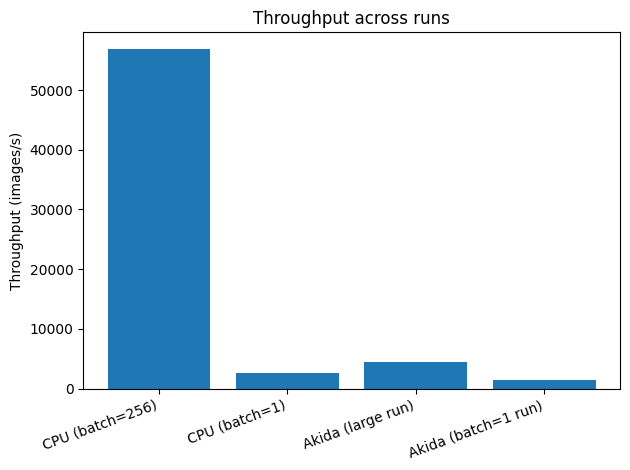

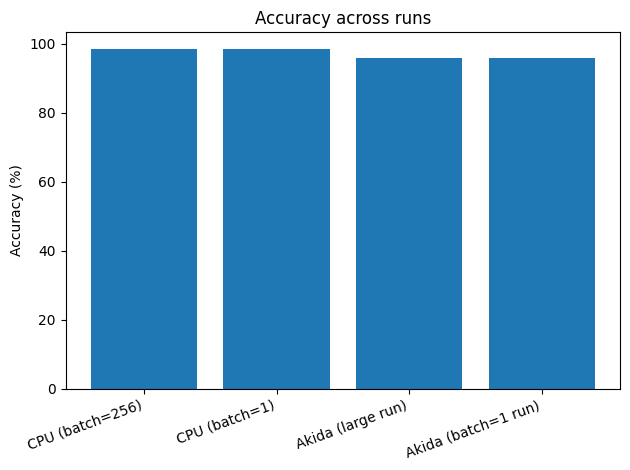

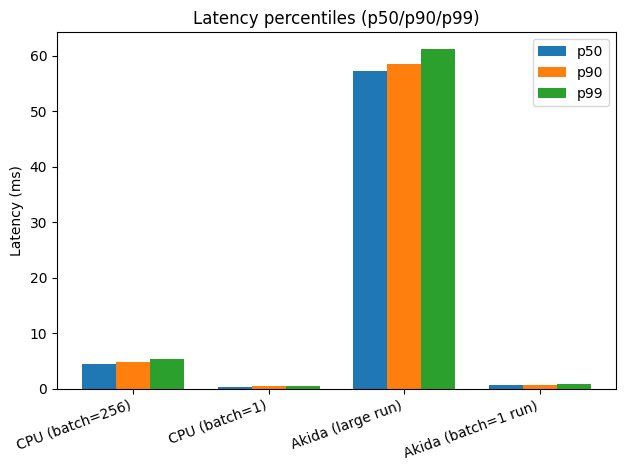

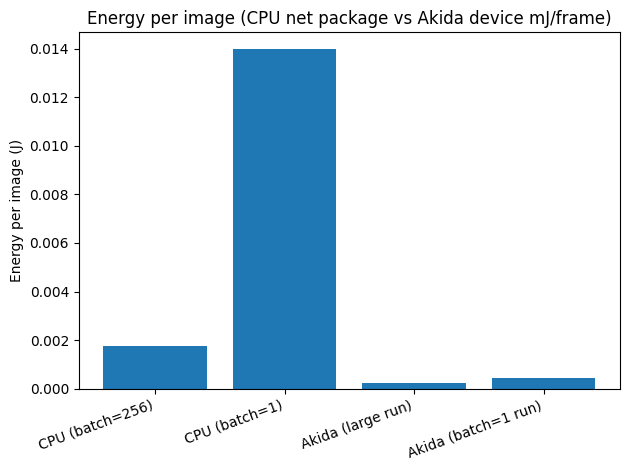

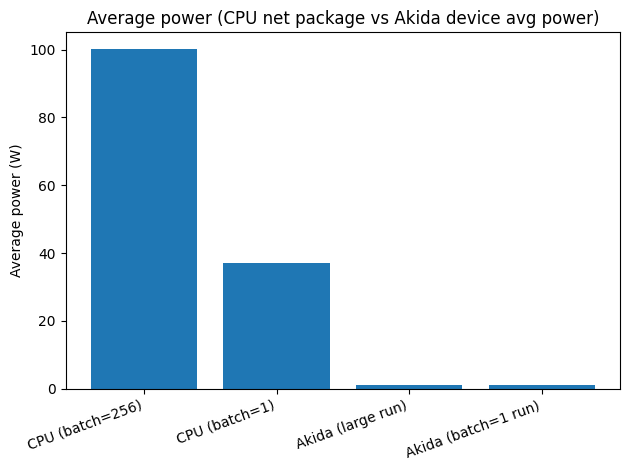

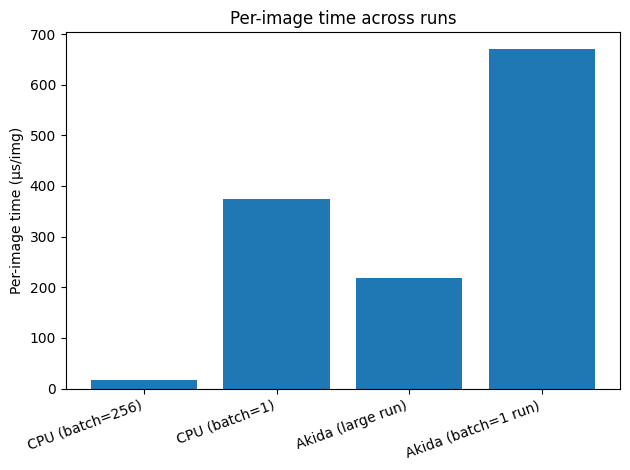

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------------
# Hardcoded results
# -------------------------
results = {
    "CPU (batch=256)": {
        "accuracy_pct": 98.42,
        "throughput_img_s": 56824.1,
        "lat_p50_ms": 4.464,
        "lat_p90_ms": 4.714,
        "lat_p99_ms": 5.431,
        "per_image_us": 17.58,
        "net_j_per_img_pkg": 0.0017616225299479163,
        "net_avg_power_w_pkg": 100.10266127832806,
    },
    "CPU (batch=1)": {
        "accuracy_pct": 98.42,
        "throughput_img_s": 2651.9,
        "lat_p50_ms": 0.367,
        "lat_p90_ms": 0.442,
        "lat_p99_ms": 0.550,
        "per_image_us": 375.18,
        "net_j_per_img_pkg": 0.013977931,
        "net_avg_power_w_pkg": 37.06759897339687,
    },
    # Akida power is mW; energy is mJ/frame
    "Akida (large run)": {
        "accuracy_pct": 96.01,
        "throughput_img_s": 4455.5,
        "lat_p50_ms": 57.190,
        "lat_p90_ms": 58.445,
        "lat_p99_ms": 61.185,
        "per_image_us": 219.17,
        "power_mw_avg": 1094.81,
        "energy_mj_per_frame": 0.24,
    },
    "Akida (batch=1 run)": {
        "accuracy_pct": 96.01,
        "throughput_img_s": 1489.4,
        "lat_p50_ms": 0.659,
        "lat_p90_ms": 0.723,
        "lat_p99_ms": 0.822,
        "per_image_us": 669.80,
        "power_mw_avg": 997.05,
        "energy_mj_per_frame": 0.44,
    }
}

labels = list(results.keys())
x = np.arange(len(labels))

# -------------------------
# Plot 1: Throughput
# -------------------------
thr = [results[k]["throughput_img_s"] for k in labels]
plt.figure()
plt.bar(x, thr)
plt.xticks(x, labels, rotation=20, ha="right")
plt.ylabel("Throughput (images/s)")
plt.title("Throughput across runs")
plt.tight_layout()
plt.show()

# -------------------------
# Plot 2: Accuracy
# -------------------------
acc = [results[k]["accuracy_pct"] for k in labels]
plt.figure()
plt.bar(x, acc)
plt.xticks(x, labels, rotation=20, ha="right")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy across runs")
plt.tight_layout()
plt.show()

# -------------------------
# Plot 3: Latency percentiles
# -------------------------
p50 = [results[k]["lat_p50_ms"] for k in labels]
p90 = [results[k]["lat_p90_ms"] for k in labels]
p99 = [results[k]["lat_p99_ms"] for k in labels]

w = 0.25
plt.figure()
plt.bar(x - w, p50, w, label="p50")
plt.bar(x,     p90, w, label="p90")
plt.bar(x + w, p99, w, label="p99")
plt.xticks(x, labels, rotation=20, ha="right")
plt.ylabel("Latency (ms)")
plt.title("Latency percentiles (p50/p90/p99)")
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------
# Plot 4: Energy per image (J)
# CPU uses net package J/img
# Akida uses mJ/frame -> J/img = mJ/1000
# -------------------------
energy_j_per_img = []
for k in labels:
    if k.startswith("CPU"):
        energy_j_per_img.append(results[k]["net_j_per_img_pkg"])
    else:
        energy_j_per_img.append(results[k]["energy_mj_per_frame"] / 1000.0)

plt.figure()
plt.bar(x, energy_j_per_img)
plt.xticks(x, labels, rotation=20, ha="right")
plt.ylabel("Energy per image (J)")
plt.title("Energy per image (CPU net package vs Akida device mJ/frame)")
plt.tight_layout()
plt.show()

# -------------------------
# Plot 5: Average power (W)
# CPU uses net package W
# Akida uses avg mW -> W
# -------------------------
power_w = []
for k in labels:
    if k.startswith("CPU"):
        power_w.append(results[k]["net_avg_power_w_pkg"])
    else:
        power_w.append(results[k]["power_mw_avg"] / 1000.0)

plt.figure()
plt.bar(x, power_w)
plt.xticks(x, labels, rotation=20, ha="right")
plt.ylabel("Average power (W)")
plt.title("Average power (CPU net package vs Akida device avg power)")
plt.tight_layout()
plt.show()

# -------------------------
# Plot 6: Per-image time (µs/img)
# -------------------------
us_img = [results[k]["per_image_us"] for k in labels]
plt.figure()
plt.bar(x, us_img)
plt.xticks(x, labels, rotation=20, ha="right")
plt.ylabel("Per-image time (µs/img)")
plt.title("Per-image time across runs")
plt.tight_layout()
plt.show()


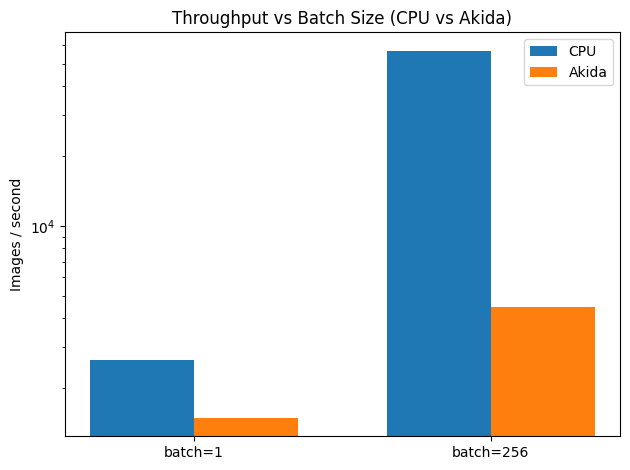

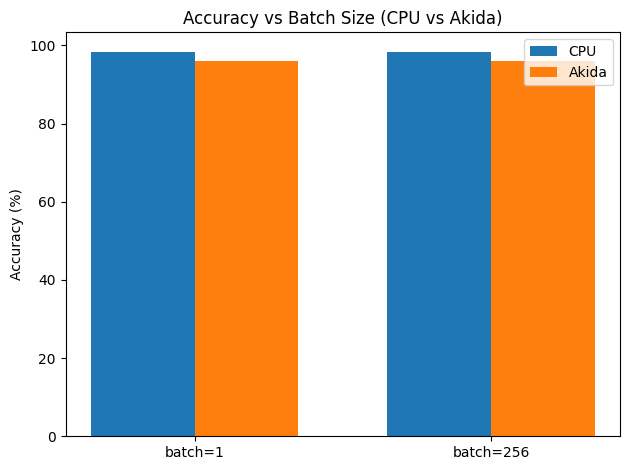

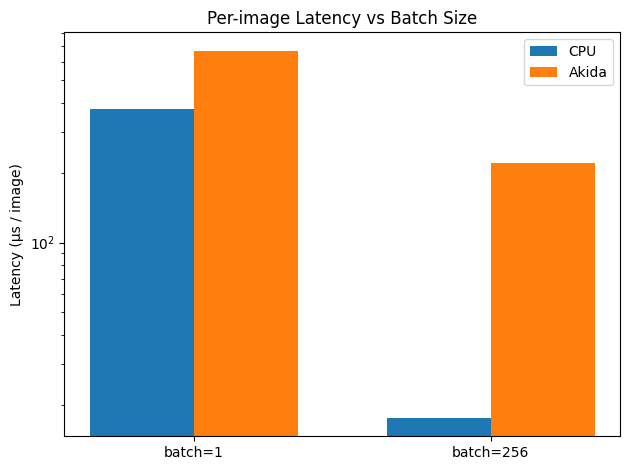

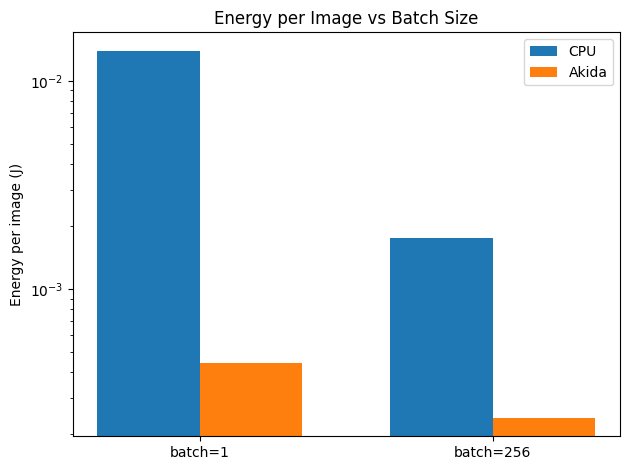

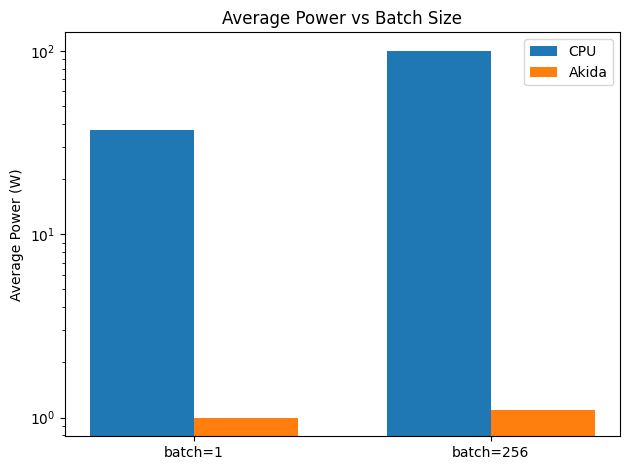

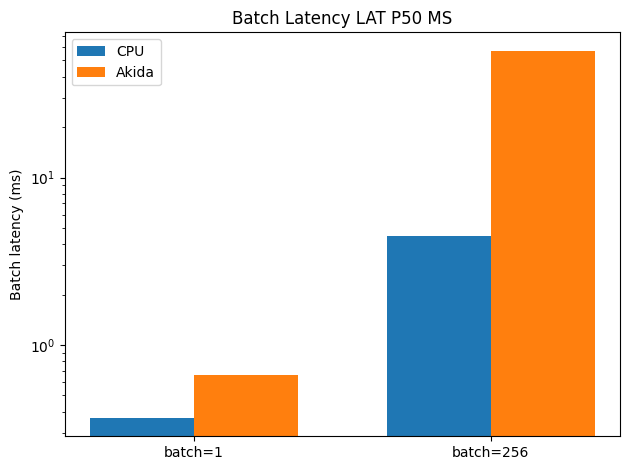

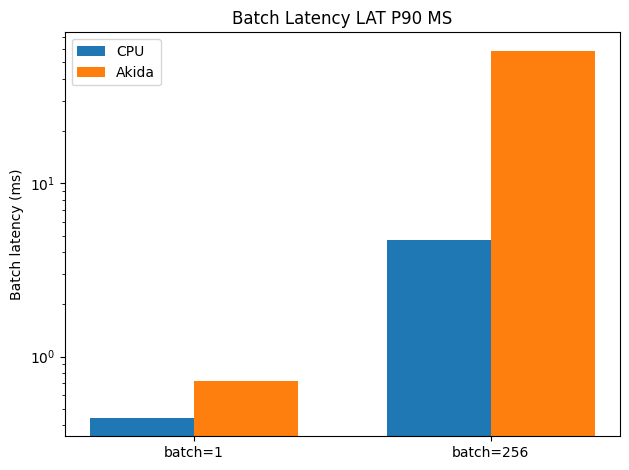

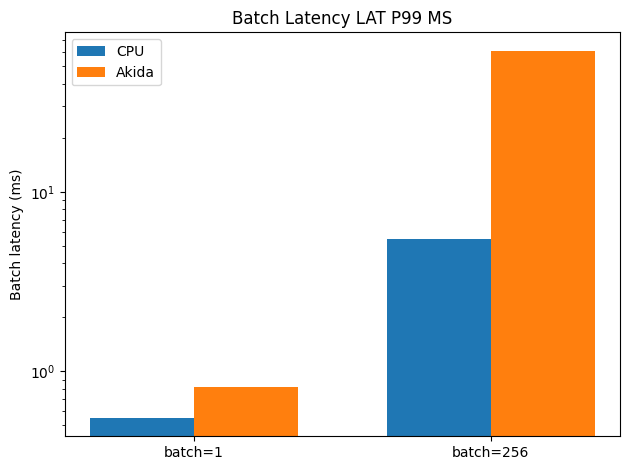

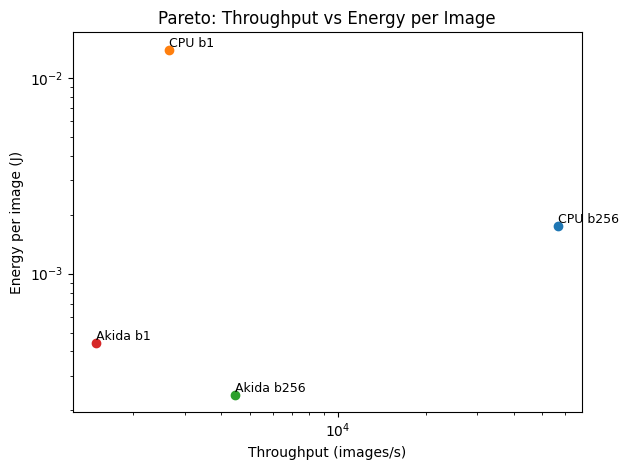

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# Hardcoded benchmark data
# =========================
data = [
    # CPU, batch 256
    {
        "platform": "CPU",
        "batch": 256,
        "accuracy": 98.42,
        "throughput": 56824.1,
        "per_image_us": 17.58,
        "lat_p50_ms": 4.464,
        "lat_p90_ms": 4.714,
        "lat_p99_ms": 5.431,
        "energy_j_img": 0.00176162253,   # net package
        "power_w": 100.10,
    },
    # CPU, batch 1
    {
        "platform": "CPU",
        "batch": 1,
        "accuracy": 98.42,
        "throughput": 2651.9,
        "per_image_us": 375.18,
        "lat_p50_ms": 0.367,
        "lat_p90_ms": 0.442,
        "lat_p99_ms": 0.550,
        "energy_j_img": 0.013977931,
        "power_w": 37.07,
    },
    # Akida, batch 256
    {
        "platform": "Akida",
        "batch": 256,
        "accuracy": 96.01,
        "throughput": 4455.5,
        "per_image_us": 219.17,
        "lat_p50_ms": 57.190,
        "lat_p90_ms": 58.445,
        "lat_p99_ms": 61.185,
        "energy_j_img": 0.24 / 1000,   # mJ/frame → J/image
        "power_w": 1.095,              # mW → W
    },
    # Akida, batch 1
    {
        "platform": "Akida",
        "batch": 1,
        "accuracy": 96.01,
        "throughput": 1489.4,
        "per_image_us": 669.80,
        "lat_p50_ms": 0.659,
        "lat_p90_ms": 0.723,
        "lat_p99_ms": 0.822,
        "energy_j_img": 0.44 / 1000,
        "power_w": 0.997,
    },
]

df = pd.DataFrame(data)

# =========================
# Helper: grouped bar plot
# =========================
def grouped_bar(metric, ylabel, title, logy=False):
    batches = sorted(df.batch.unique())
    platforms = ["CPU", "Akida"]
    x = np.arange(len(batches))
    w = 0.35

    vals_cpu = [df[(df.batch==b)&(df.platform=="CPU")][metric].values[0] for b in batches]
    vals_ak  = [df[(df.batch==b)&(df.platform=="Akida")][metric].values[0] for b in batches]

    plt.figure()
    plt.bar(x - w/2, vals_cpu, w, label="CPU")
    plt.bar(x + w/2, vals_ak,  w, label="Akida")
    plt.xticks(x, [f"batch={b}" for b in batches])
    plt.ylabel(ylabel)
    plt.title(title)
    if logy:
        plt.yscale("log")
    plt.legend()
    plt.tight_layout()
    plt.show()

# =========================
# Plots
# =========================

# 1️⃣ Throughput
grouped_bar(
    "throughput",
    "Images / second",
    "Throughput vs Batch Size (CPU vs Akida)",
    logy=True
)

# 2️⃣ Accuracy
grouped_bar(
    "accuracy",
    "Accuracy (%)",
    "Accuracy vs Batch Size (CPU vs Akida)"
)

# 3️⃣ Per-image latency
grouped_bar(
    "per_image_us",
    "Latency (µs / image)",
    "Per-image Latency vs Batch Size",
    logy=True
)

# 4️⃣ Energy per image
grouped_bar(
    "energy_j_img",
    "Energy per image (J)",
    "Energy per Image vs Batch Size",
    logy=True
)

# 5️⃣ Average power
grouped_bar(
    "power_w",
    "Average Power (W)",
    "Average Power vs Batch Size",
    logy=True
)

# =========================
# Latency percentiles
# =========================
for pct in ["lat_p50_ms", "lat_p90_ms", "lat_p99_ms"]:
    grouped_bar(
        pct,
        "Batch latency (ms)",
        f"Batch Latency {pct.replace('_',' ').upper()}",
        logy=True
    )

# =========================
# Pareto plot
# =========================
plt.figure()
for _, r in df.iterrows():
    plt.scatter(r.throughput, r.energy_j_img)
    plt.text(
        r.throughput,
        r.energy_j_img,
        f"{r.platform} b{r.batch}",
        fontsize=9,
        ha="left",
        va="bottom"
    )

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Throughput (images/s)")
plt.ylabel("Energy per image (J)")
plt.title("Pareto: Throughput vs Energy per Image")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# -------------------------
# Hardcoded benchmark data
# -------------------------
data = [
    # CPU
    {"platform": "CPU", "batch": 256, "accuracy": 98.42, "throughput": 56824.1,
     "per_image_us": 17.58, "energy_j_img": 0.00176162253, "power_w": 100.10},
    {"platform": "CPU", "batch": 1, "accuracy": 98.42, "throughput": 2651.9,
     "per_image_us": 375.18, "energy_j_img": 0.013977931, "power_w": 37.07},

    # Akida
    {"platform": "Akida", "batch": 256, "accuracy": 96.01, "throughput": 4455.5,
     "per_image_us": 219.17, "energy_j_img": 0.24/1000, "power_w": 1.095},
    {"platform": "Akida", "batch": 1, "accuracy": 96.01, "throughput": 1489.4,
     "per_image_us": 669.80, "energy_j_img": 0.44/1000, "power_w": 0.997},
]

df = pd.DataFrame(data)

# -------------------------
# Comparison per batch size
# -------------------------
def compare_batch(batch):
    cpu = df[(df.batch == batch) & (df.platform == "CPU")].iloc[0]
    ak  = df[(df.batch == batch) & (df.platform == "Akida")].iloc[0]

    print(f"\n=== CPU vs Akida (batch = {batch}) ===")

    print(f"Accuracy:")
    print(f"  CPU   : {cpu.accuracy:.2f}%")
    print(f"  Akida : {ak.accuracy:.2f}%")
    print(f"  Δ     : {cpu.accuracy - ak.accuracy:.2f} percentage points")

    print(f"\nThroughput (img/s):")
    print(f"  CPU / Akida speedup : {cpu.throughput / ak.throughput:.2f}×")

    print(f"\nEnergy per image (J):")
    print(f"  CPU / Akida energy ratio : {cpu.energy_j_img / ak.energy_j_img:.2f}×")

    print(f"\nAverage power (W):")
    print(f"  CPU / Akida power ratio  : {cpu.power_w / ak.power_w:.2f}×")

    print(f"\nPer-image latency (µs):")
    print(f"  CPU / Akida latency ratio: {cpu.per_image_us / ak.per_image_us:.2f}×")

# -------------------------
# Run comparisons
# -------------------------
compare_batch(256)
compare_batch(1)



=== CPU vs Akida (batch = 256) ===
Accuracy:
  CPU   : 98.42%
  Akida : 96.01%
  Δ     : 2.41 percentage points

Throughput (img/s):
  CPU / Akida speedup : 12.75×

Energy per image (J):
  CPU / Akida energy ratio : 7.34×

Average power (W):
  CPU / Akida power ratio  : 91.42×

Per-image latency (µs):
  CPU / Akida latency ratio: 0.08×

=== CPU vs Akida (batch = 1) ===
Accuracy:
  CPU   : 98.42%
  Akida : 96.01%
  Δ     : 2.41 percentage points

Throughput (img/s):
  CPU / Akida speedup : 1.78×

Energy per image (J):
  CPU / Akida energy ratio : 31.77×

Average power (W):
  CPU / Akida power ratio  : 37.18×

Per-image latency (µs):
  CPU / Akida latency ratio: 0.56×
